In [1]:
import os
import shap
import wandb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor


c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
language_map = {
    "same": "English",
    "avg": "Average",
    "af": "Afrikaans",
    "ar": "Arabic",
    "bg": "Bulgarian",
    "ca": "Catalan",
    "cs": "Czech",
    "da": "Danish",
    "de": "German",
    "el": "Greek",
    "es": "Spanish",
    "fa": "Persian",
    "fi": "Finnish",
    "fr": "French",
    "he": "Hebrew",
    "hi": "Hindi",
    "hu": "Hungarian",
    "it": "Italian",
    "ja": "Japanese",
    "ko": "Korean",
    "lt": "Lithuanian",
    "lv": "Latvian",
    "no": "Norwegian",
    "pl": "Polish",
    "pt": "Portuguese",
    "ro": "Romanian",
    "ru": "Russian",
    "sk": "Slovak",
    "sl": "Slovenian",
    "sv": "Swedish",
    "ta": "Tamil",
    "th": "Thai",
    "tr": "Turkish",
    "uk": "Ukrainian",
    "vi": "Vietnamese",
    "zh": "Chinese",
    "sw": "Swahili",
    "ur": "Urdu",
    "en": "English"
}

In [3]:
method_names = {
    'baseline': 'Fine-tuning Only',
    'before_fastalign': 'Before FastAlign',
    'before_awesome': 'Before Awesome',
    'before_dico': 'Before Dict',
    'during_fastalign': 'During FastAlign',
    'during_awesome': 'During Awesome',
    'during_dico': 'During Dict',
    'freeze_realign_unfreeze_fastalign': 'Before - Front Freeze FastAlign',
    'freeze_realign_unfreeze_awesome': 'Before - Front Freeze Awesome',
    'freeze_realign_unfreeze_dico': 'Before - Front Freeze Dict',
    'freeze_realign_unfreeze_last_6_fastalign': 'Before - Back Freeze FastAlign',
    'freeze_realign_unfreeze_last_6_awesome': 'Before - Back Freeze Awesome',
    'freeze_realign_unfreeze_last_6_dico': 'Before - Back Freeze Dict',
    'during_partial_freeze_front_fastalign': 'During Front Freeze FastAlign',
    'during_partial_freeze_front_awesome': 'During Front Freeze Awesome',
    'during_partial_freeze_front_dico': 'During Front Freeze Dict',
    'during_partial_freeze_back_fastalign': 'During Back Freeze FastAlign',
    'during_partial_freeze_back_awesome': 'During Back Freeze Awesome',
    'during_partial_freeze_back_dico': 'During Back Freeze Dict',
}

In [4]:
specific_language_families = {
    'ja': 'East Asian',
    'th': 'Southeast Asian',
    'ta': 'South Asian',
    'vi': 'Southeast Asian',
    'ko': 'East Asian',
    'ar': 'Middle Eastern',
    'he': 'Middle Eastern',
    'zh': 'East Asian',
    'hi': 'South Asian',
    'tr': 'Middle Eastern',
    'en': 'European',
    'fa': 'Middle Eastern',
    'lv': 'European',
    'lt': 'European',
    'avg': 'European',
    'el': 'European',
    'sv': 'European',
    'no': 'European',
    'hu': 'European',
    'da': 'European',
    'de': 'European',
    'ca': 'European',
    'bg': 'European',
    'fr': 'European',
    'af': 'European',
    'es': 'European',
    'it': 'European',
    'uk': 'European',
    'sk': 'European',
    'fi': 'European',
    'cs': 'European',
    'pt': 'European',
    'pl': 'European',
    'ru': 'European',
    'ro': 'European',
    'sl': 'European'
}

In [5]:
specific_family_shapes = {
    'East Asian': 'o',  
    'Southeast Asian': '^',  
    'South Asian': 's',  
    'European': 'P',  
    'Middle Eastern': 'v', 
    'Other': 'p' 
}

In [6]:
api = wandb.Api()
workspace = "align_freeze"
finetuning_project_name = "3nl_34langs_baseline_udpos"

In [7]:
langs = ["same", "avg", "af", "ar", "bg", "ca", "cs", "da", "de", "el", "es", "fa", "fi", "fr", "he", "hi",
         "hu", "it", "ja", "ko", "lt", 'lv', 'no', 'pl', 'pt', 'ro', 'ru', 'sk', 'sl', 'sv', 'ta', 'th', 'tr', 'uk',
         'vi', 'zh']

In [8]:
def fetch_and_process_runs(source, _langs, username="felixgaschi", method_name=None):
    runs_data = {lang: [] for lang in _langs}
    
    runs = api.runs(f"{workspace}/{source}")
    for run in runs:
        if run.user.username == username:  
            for lang in langs:
                accuracy_key = f"final_eval_{lang}_accuracy"
                accuracy = run.summary.get(accuracy_key)
                if accuracy is not None:
                    runs_data[lang].append(accuracy)
    return runs_data

In [9]:
def load_baseline_csv(csv_directory, model_name):
    csv_file = [os.path.join(csv_directory, file) for file in os.listdir(csv_directory) if 'filtered_percentage' not in file]
    baseline_df = pd.read_csv(csv_file[0])
    baseline_df['value'] = 0.0
    baseline_df['model'] = model_name
    return baseline_df

In [10]:
def load_and_combine_csvs(csv_directory):
    csv_files = [os.path.join(csv_directory, file) for file in os.listdir(csv_directory) if file.endswith('.csv')]
    dfs = {}
    for file in csv_files:
        file_name = os.path.basename(file)
        if "filtered_percent_" in file_name:
            value = float(file_name.split('filtered_percent_')[-1].replace('.csv', ''))
        elif "filtered_" in file_name:
            value = float(file_name.split('filtered_')[-1].replace('.csv', ''))
        else:
            value = 0.0
        df = pd.read_csv(file)
        df['value'] = value
        dfs[value] = df
    combined_df = pd.concat(dfs.values(), ignore_index=True)
    return combined_df

In [11]:
def transform_data_for_regression(df, id_vars):
    language_columns = [col for col in df.columns if col.startswith('final_eval_') and col.endswith('_accuracy')]
    melted_df = df.melt(id_vars=id_vars, value_vars=language_columns, 
                        var_name='language_accuracy', value_name='accuracy')
    melted_df['language_code'] = melted_df['language_accuracy'].apply(lambda x: x.split('_')[2])
    melted_df = melted_df.drop(columns=['language_accuracy'])
    melted_df['language_code'] = melted_df['language_code'].astype('category')
    
    if 'method' in id_vars:
        melted_df['method'] = melted_df['method'].map(method_names).fillna(melted_df['method'])
        melted_df['method'] = melted_df['method'].astype('category')
        
    if 'value' in id_vars:
        melted_df['value'] = melted_df['value'].astype('category')
        
    if 'model' in id_vars:
        melted_df['model'] = melted_df['model'].astype('category')
    
    return melted_df


In [12]:
def standardize_xlmr_columns(df):
    df.columns = [f'final_eval_{col}_accuracy' if col in langs else col for col in df.columns]
    return df

In [13]:
def perform_random_forest_regression(grouped_data, id_vars):
    grouped_data = grouped_data.dropna(subset=['accuracy'])
    encoded_df = pd.get_dummies(grouped_data, columns=id_vars + ['language_code'], drop_first=False)
    X = encoded_df.drop('accuracy', axis=1)
    y = encoded_df['accuracy']
    
    regression_model = RandomForestRegressor(n_estimators=100, random_state=42)
    regression_model.fit(X, y)
    importances = regression_model.feature_importances_
    coefficients = pd.Series(importances, index=X.columns)
    
    return coefficients, encoded_df.columns


In [14]:
def group_by_subset(df, subset):
    # Drop rows with NaN values in the specified subset columns and 'accuracy' column
    df = df.dropna(subset=subset + ['accuracy'])

    # Remove duplicate rows
    df = df.drop_duplicates()

    # Ensure columns are of correct data types
    for col in subset:
        df[col] = df[col].astype('category')
    df['accuracy'] = df['accuracy'].astype(float)

    # Check for duplicates again
    duplicates = df.duplicated(subset=subset, keep=False)
    print(f"Number of duplicate rows: {duplicates.sum()}")

    # Check for unique combinations
    unique_combinations = df.drop_duplicates(subset=subset)
    print(f"Unique combinations shape: {unique_combinations.shape}")

    # Display unique combinations to ensure correctness
    print(unique_combinations.head())

    # Pivot the DataFrame to compute the mean accuracy for each combination of the subset columns
    grouped_df = df.pivot_table(index=subset, values='accuracy', aggfunc='mean').reset_index()

    print(grouped_df.head())
    print(f"Grouped DF Shape: {grouped_df.shape}")

    return grouped_df

In [15]:
def plot_aggregated_coefficients(coefficients, id_vars, feature_names, title, y_labels):
    factor_names = {
        'Method': [name for name in feature_names if name.startswith('method')],
        'Language Code': [name for name in feature_names if name.startswith('language_code')]
    }
    for var in id_vars:
        if var not in factor_names:
            factor_names[var] = [name for name in feature_names if name.startswith(var)]
    
    aggregated_coefficients = {factor.title(): coefficients[factor_names[factor]].sum() for factor in factor_names}
    aggregated_coefficients_series = pd.Series(aggregated_coefficients).sort_values(ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x=aggregated_coefficients_series.values, y=aggregated_coefficients_series.index, palette='viridis', edgecolor='black', hue=aggregated_coefficients_series.index)
    plt.title(title, fontsize=16)
    plt.xlabel('Importance', fontsize=14)
    plt.ylabel('Feature', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Set custom y-tick labels
    y_tick_labels = [y_labels.get(label, label) for label in aggregated_coefficients_series.index]
    plt.gca().set_yticklabels(y_tick_labels, fontsize=12)

    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [16]:
def plot_detailed_coefficients(coefficients, id_vars, title, custom_y_label=None):
    language_coefficients = coefficients.filter(like='language_code_').rename(index=lambda x: language_map.get(x.replace('language_code_', ''), x))
    language_coefficients = language_coefficients.sort_values(ascending=False)

    plt.figure(figsize=(14, 14))
    sns.barplot(x=language_coefficients.values, y=language_coefficients.index, palette='coolwarm', edgecolor='black', hue=language_coefficients.index, legend=False)
    plt.title(f'{title} - Languages')
    plt.xlabel('Importance')
    plt.ylabel('Languages')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    method_coefficients = coefficients.filter(like='method_').rename(index=lambda x: method_names.get(x.replace('method_', ''), x))
    method_coefficients = method_coefficients.rename(index=lambda x: x.replace('method_', ''))
    method_coefficients = method_coefficients.sort_values(ascending=False)

    plt.figure(figsize=(14, 10))
    sns.barplot(x=method_coefficients.values, y=method_coefficients.index, palette='coolwarm', edgecolor='black', hue=method_coefficients.index, legend=False)
    plt.title(f'{title} - Methods')
    plt.xlabel('Importance')
    plt.ylabel('Method')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    for var in id_vars:
        if var not in ['language_code', 'method']:
            other_coefficients = coefficients.filter(like=f'{var}_').rename(index=lambda x: x.replace(f'{var}_', ''))
            other_coefficients = other_coefficients.sort_values(ascending=False)

            plt.figure(figsize=(8, 6))
            sns.barplot(x=other_coefficients.values, y=other_coefficients.index, palette='coolwarm', edgecolor='black', hue=other_coefficients.index, legend=False)
            plt.title(f'{title} - {custom_y_label if custom_y_label else var.capitalize()}')
            plt.xlabel('Importance')
            plt.ylabel(custom_y_label if custom_y_label else var.capitalize())
            plt.grid(axis='x', linestyle='--', alpha=0.7)
            plt.tight_layout()
            plt.show()


Number of duplicate rows: 16878
Unique combinations shape: (3420, 4)
              method value  accuracy language_code
0   Fine-tuning Only   0.4  0.897609            bg
5     Before Awesome   0.4  0.893984            bg
10       Before Dict   0.4  0.889532            bg
15  During FastAlign   0.4  0.880819            bg
20    During Awesome   0.4  0.879929            bg
                         method language_code value  accuracy
0  Before - Back Freeze Awesome            af   0.4  0.886910
1  Before - Back Freeze Awesome            af   0.5  0.886379
2  Before - Back Freeze Awesome            af   0.6  0.886736
3  Before - Back Freeze Awesome            af   0.7  0.886875
4  Before - Back Freeze Awesome            af   0.8  0.886915
Grouped DF Shape: (3420, 4)


C:\Users\alith\AppData\Local\Temp\ipykernel_43892\1655974445.py:25: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  grouped_df = df.pivot_table(index=subset, values='accuracy', aggfunc='mean').reset_index()
C:\Users\alith\AppData\Local\Temp\ipykernel_43892\1212819453.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(y_tick_labels, fontsize=12)


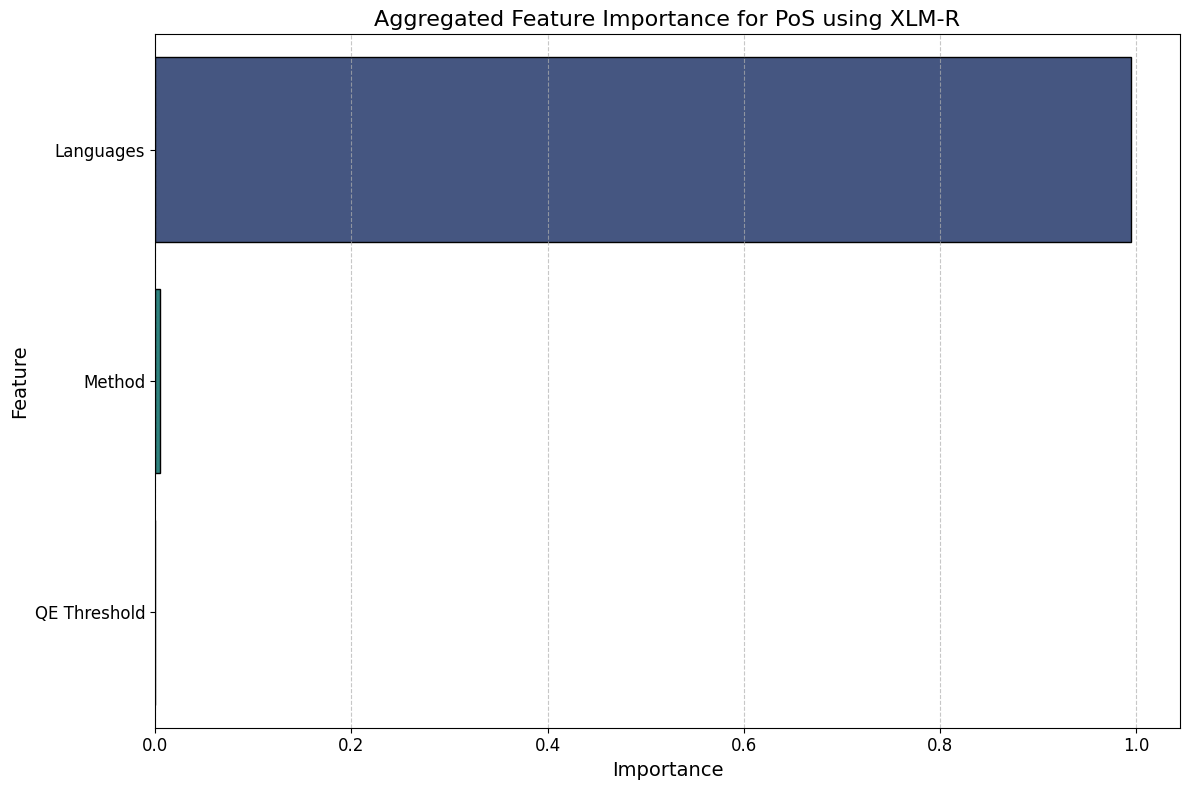

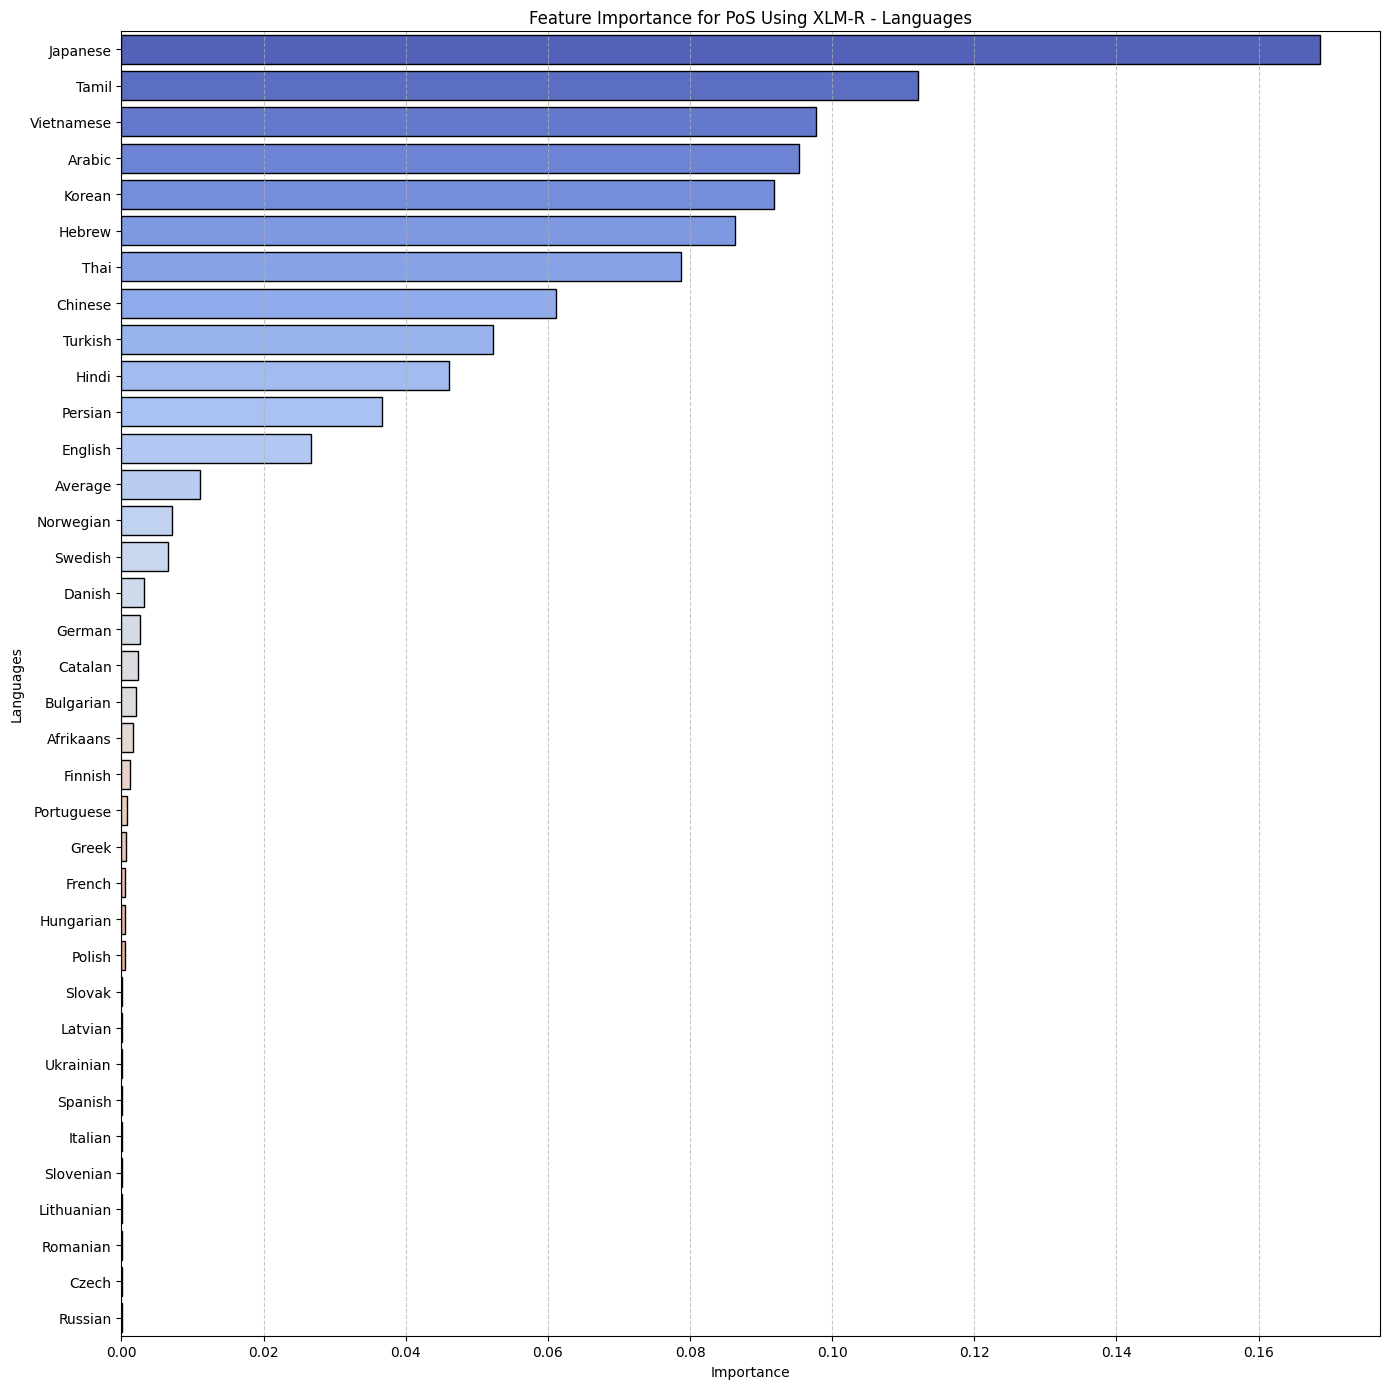

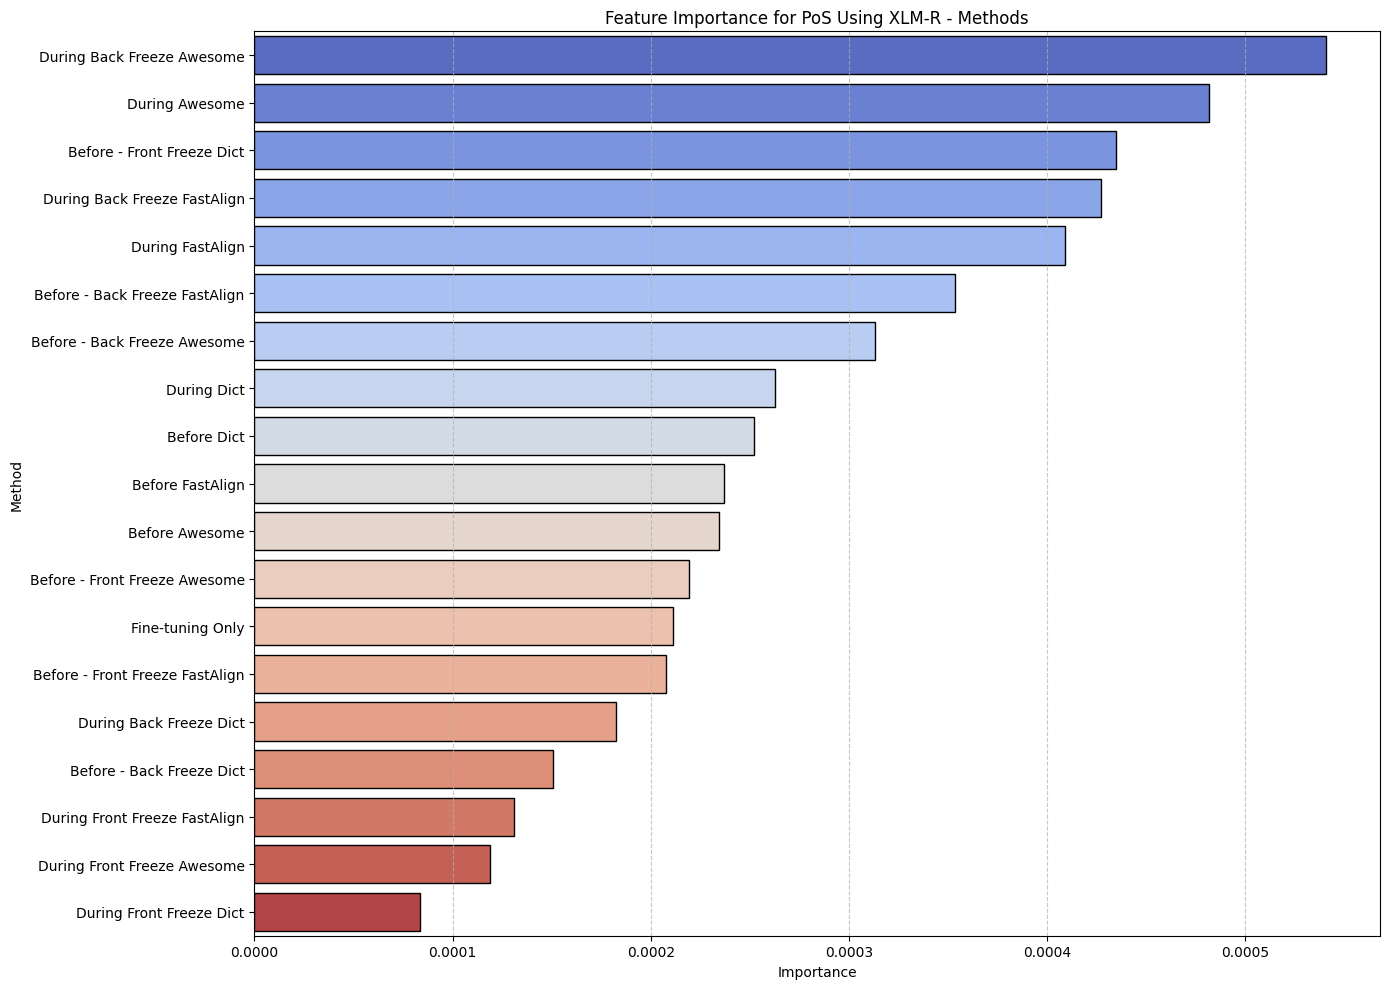

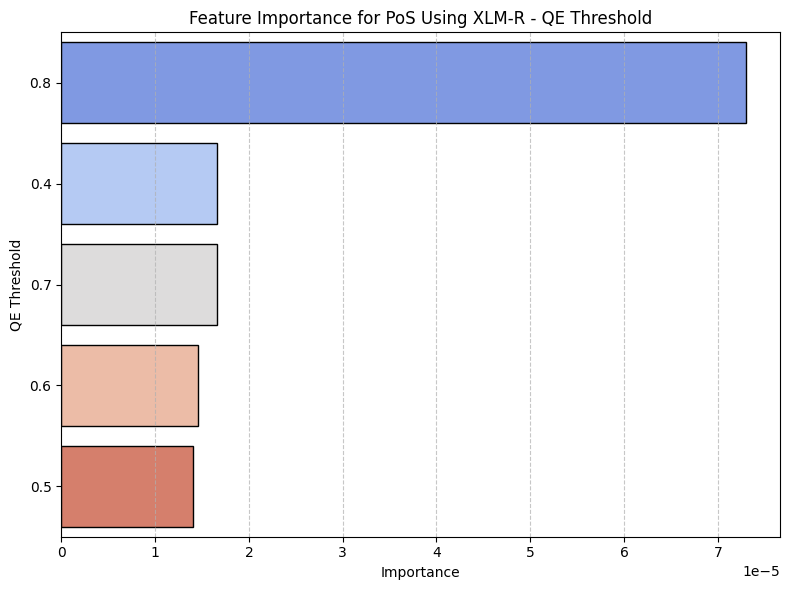

In [17]:
csv_directory_xlmr = './xlmr_threshold_data'
xlmr_df = load_and_combine_csvs(csv_directory_xlmr)

id_vars = ['method', 'value']
y_labels = {
    'Method': 'Method',
    'Language Code': 'Languages',
    'Value': 'QE Threshold'
}
melted_df = transform_data_for_regression(xlmr_df, id_vars)

subset_columns = ['method', 'language_code', 'value']
grouped_data = group_by_subset(melted_df, subset_columns)

rf_coefficients, feature_names = perform_random_forest_regression(grouped_data, id_vars)
plot_aggregated_coefficients(rf_coefficients, id_vars, feature_names, 'Aggregated Feature Importance for PoS using XLM-R', y_labels)
plot_detailed_coefficients(rf_coefficients, id_vars, 'Feature Importance for PoS Using XLM-R', 'QE Threshold')

Number of duplicate rows: 3552
Unique combinations shape: (720, 4)
              method        model  accuracy language_code
0   Before FastAlign  distilMBERT  0.875413            bg
5     Before Awesome  distilMBERT  0.874968            bg
10       Before Dict  distilMBERT  0.877448            bg
15  During FastAlign  distilMBERT  0.865111            bg
20    During Awesome  distilMBERT  0.865747            bg
                         method        model language_code  accuracy
0  Before - Back Freeze Awesome  distilMBERT            af  0.863825
1  Before - Back Freeze Awesome  distilMBERT            ar  0.631455
2  Before - Back Freeze Awesome  distilMBERT           avg  0.772346
3  Before - Back Freeze Awesome  distilMBERT            bg  0.874981
4  Before - Back Freeze Awesome  distilMBERT            ca  0.881710
Grouped DF Shape: (720, 4)


C:\Users\alith\AppData\Local\Temp\ipykernel_43892\1655974445.py:25: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  grouped_df = df.pivot_table(index=subset, values='accuracy', aggfunc='mean').reset_index()
C:\Users\alith\AppData\Local\Temp\ipykernel_43892\1212819453.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(y_tick_labels, fontsize=12)


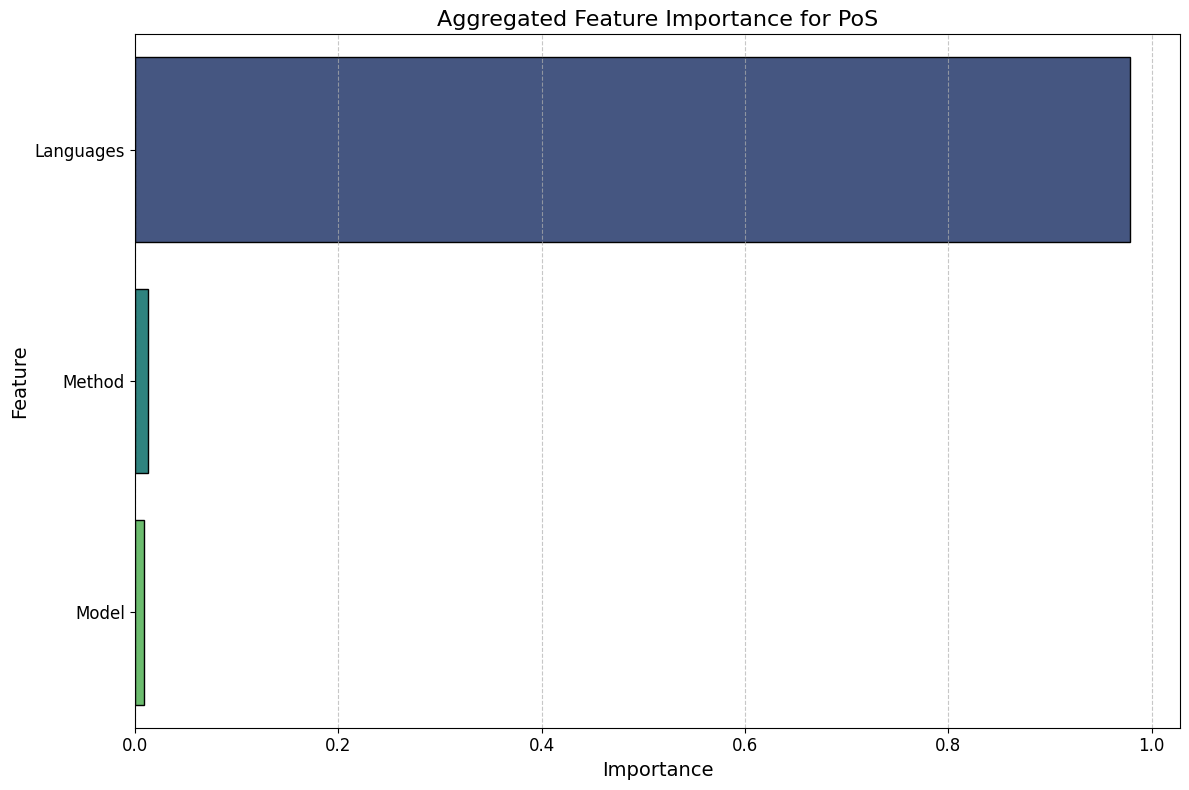

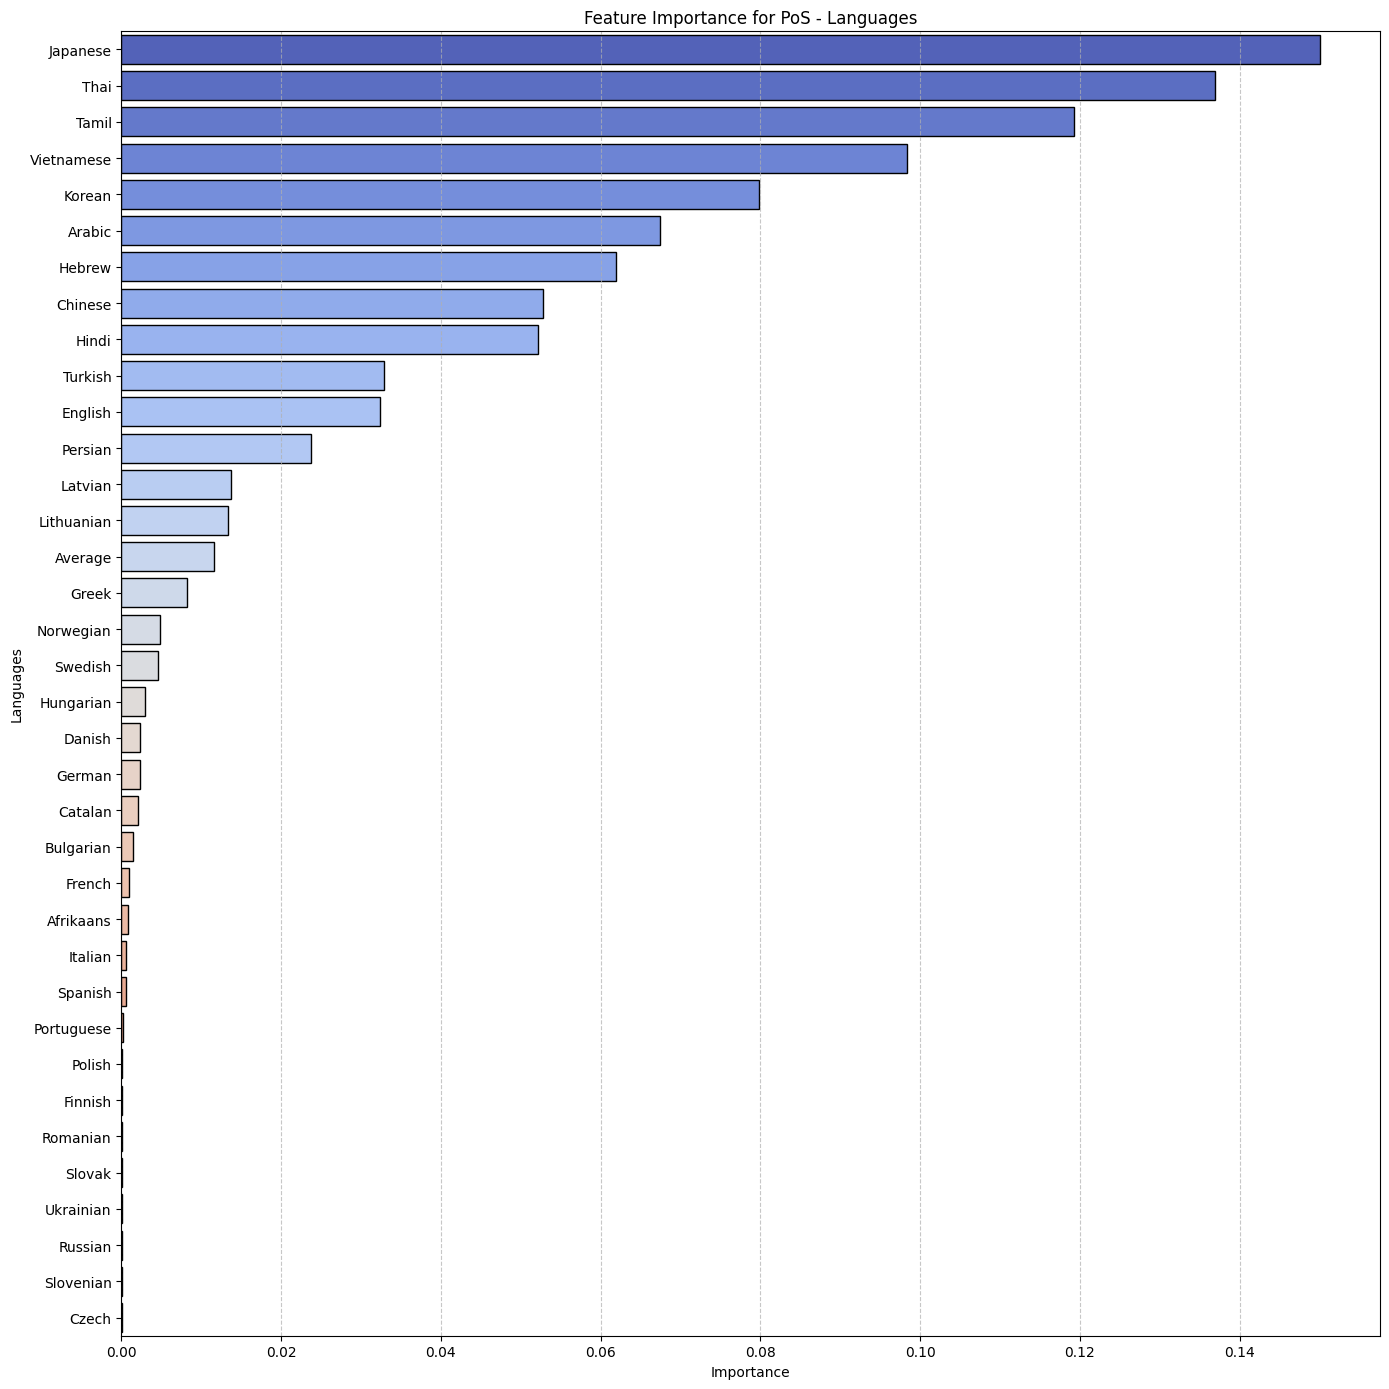

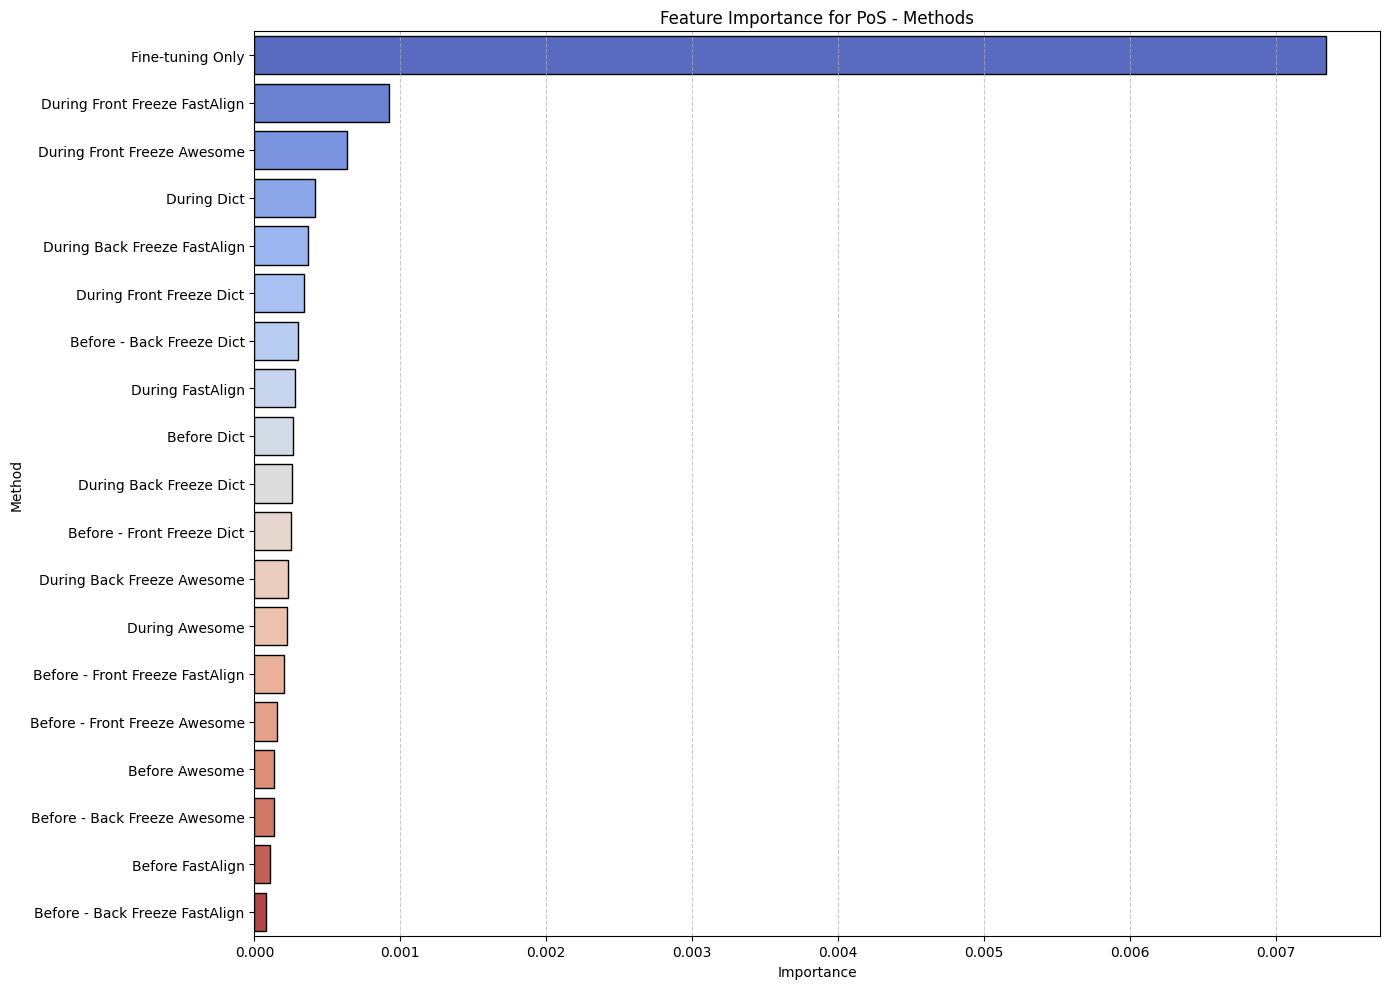

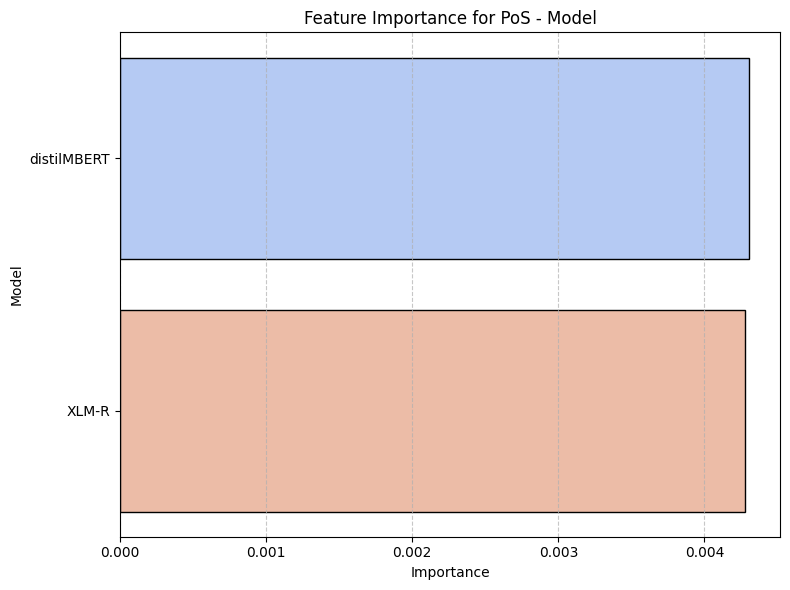

In [19]:
xlmr_baseline_data = fetch_and_process_runs(finetuning_project_name, langs)
xlmr_baseline_df = pd.DataFrame(xlmr_baseline_data)
xlmr_baseline_df['method'] = 'baseline'
xlmr_baseline_df['value'] = 0.0
xlmr_baseline_df['model'] = 'XLM-R'

xlmr_baseline_df = standardize_xlmr_columns(xlmr_baseline_df)

csv_directory_distilMBERT = './distilMBERT_percentile_data'
distilMBERT_baseline_df = load_baseline_csv(csv_directory_distilMBERT, 'distilMBERT')
combined_df = pd.concat([distilMBERT_baseline_df, xlmr_baseline_df], ignore_index=True)

combined_df = combined_df.dropna(axis=1, how='any')

id_vars = ['method', 'model']
y_labels = {
    'Method': 'Method',
    'Language Code': 'Languages',
}
melted_df = transform_data_for_regression(combined_df, id_vars)

subset_columns = ['method', 'model', 'language_code']
grouped_data = group_by_subset(melted_df, subset_columns)

rf_coefficients, feature_names = perform_random_forest_regression(grouped_data, id_vars)

plot_aggregated_coefficients(rf_coefficients, id_vars, feature_names, 'Aggregated Feature Importance for PoS', y_labels)
plot_detailed_coefficients(rf_coefficients, id_vars, 'Feature Importance for PoS')


Number of duplicate rows: 19352
Unique combinations shape: (3924, 4)
              method value  accuracy language_code
0   Before FastAlign   0.0  0.875413            bg
5     Before Awesome   0.0  0.874968            bg
10       Before Dict   0.0  0.877448            bg
15  During FastAlign   0.0  0.865111            bg
20    During Awesome   0.0  0.865747            bg
                         method language_code value  accuracy
0  Before - Back Freeze Awesome            af   0.0  0.863825
1  Before - Back Freeze Awesome            af  25.0  0.865395
2  Before - Back Freeze Awesome            af  37.0  0.865554
3  Before - Back Freeze Awesome            af  50.0  0.865057
4  Before - Back Freeze Awesome            af  62.0  0.865713
Grouped DF Shape: (3924, 4)


C:\Users\alith\AppData\Local\Temp\ipykernel_43892\1655974445.py:25: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  grouped_df = df.pivot_table(index=subset, values='accuracy', aggfunc='mean').reset_index()
C:\Users\alith\AppData\Local\Temp\ipykernel_43892\1212819453.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(y_tick_labels, fontsize=12)


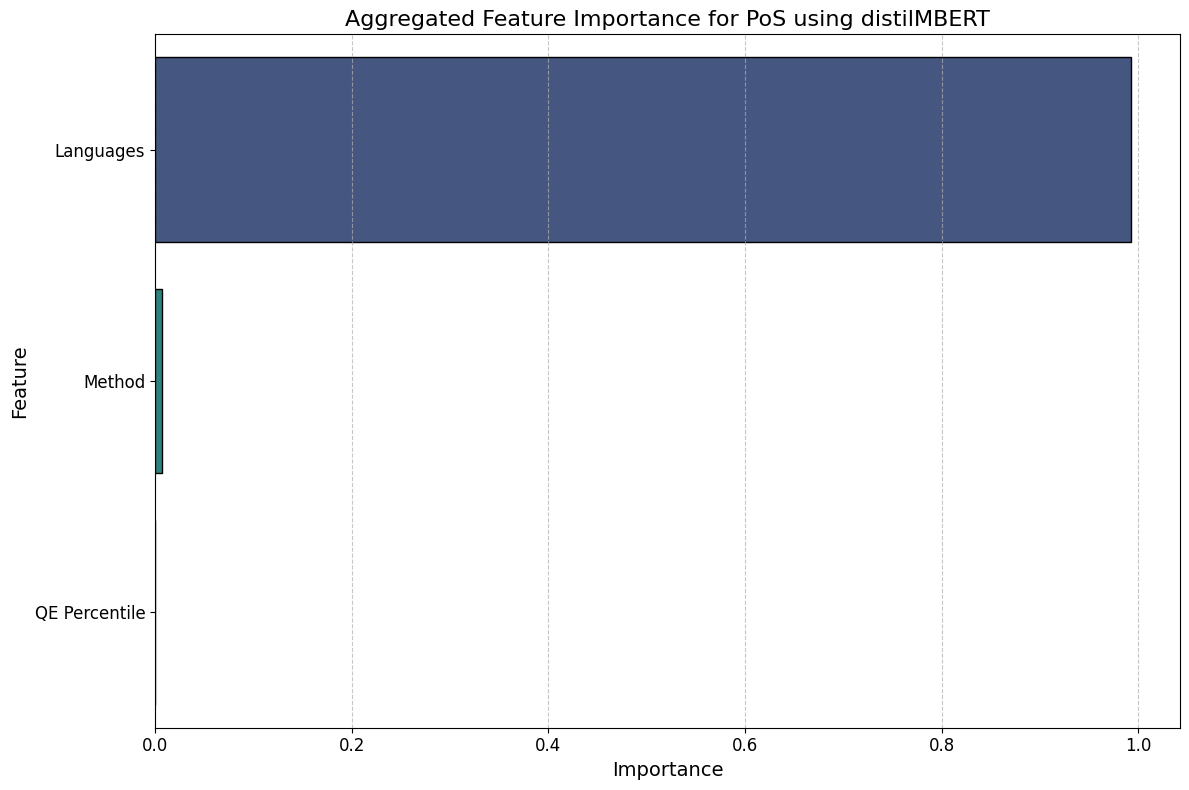

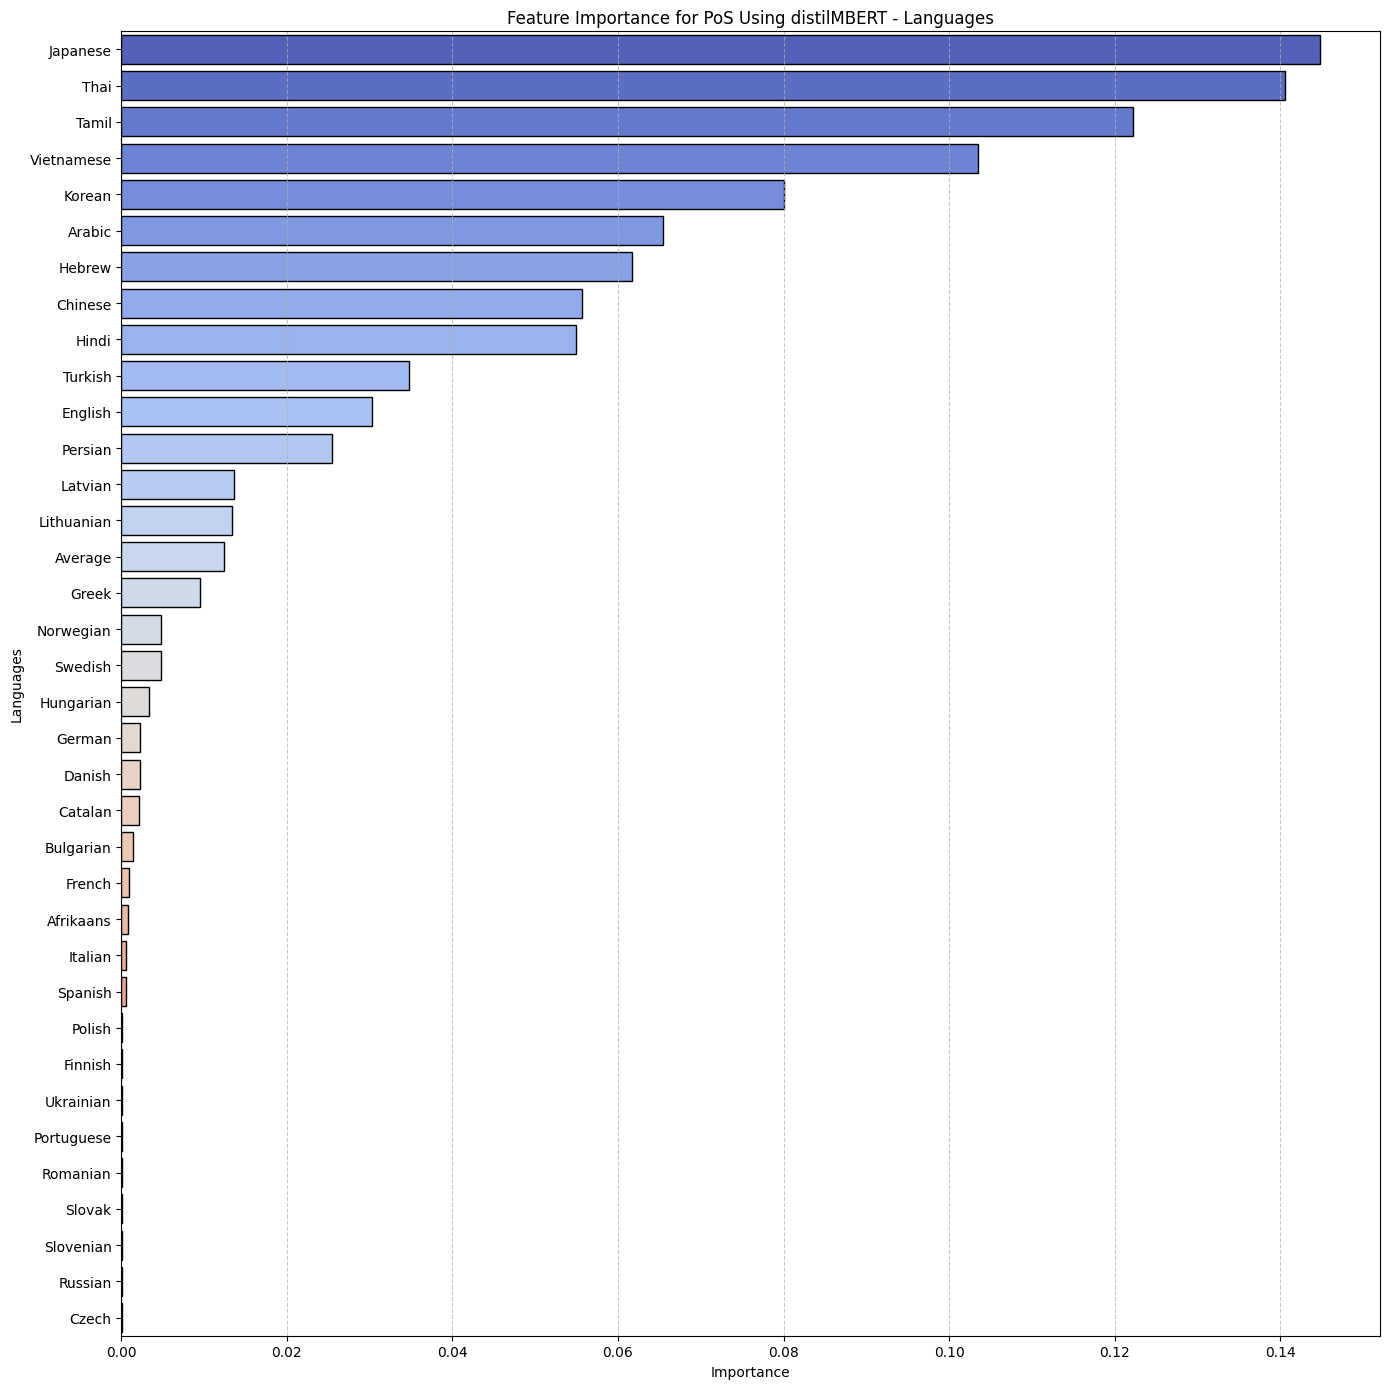

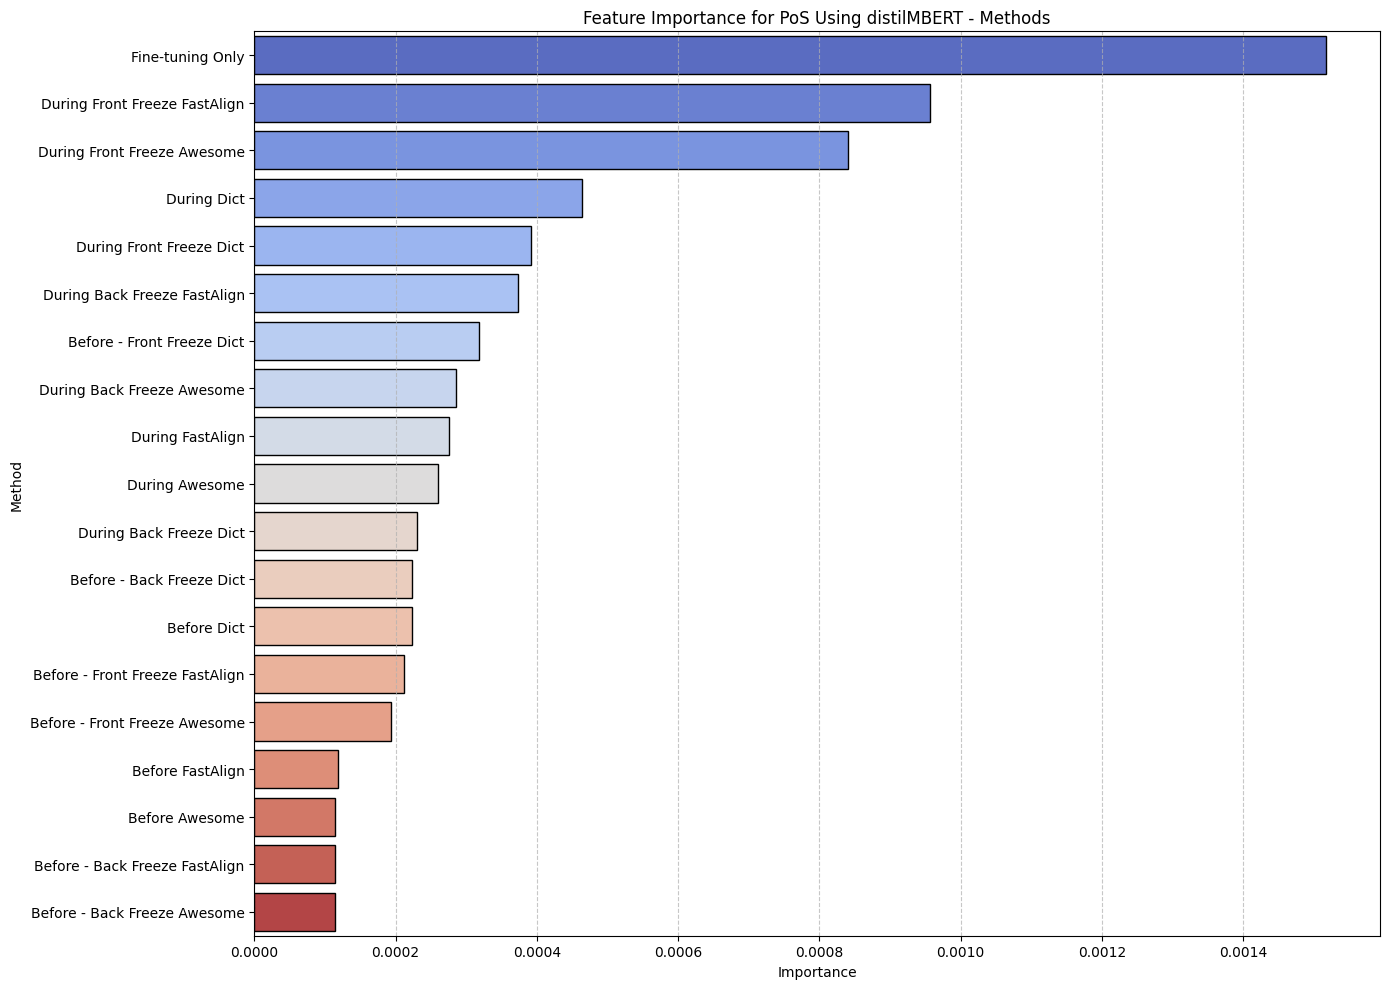

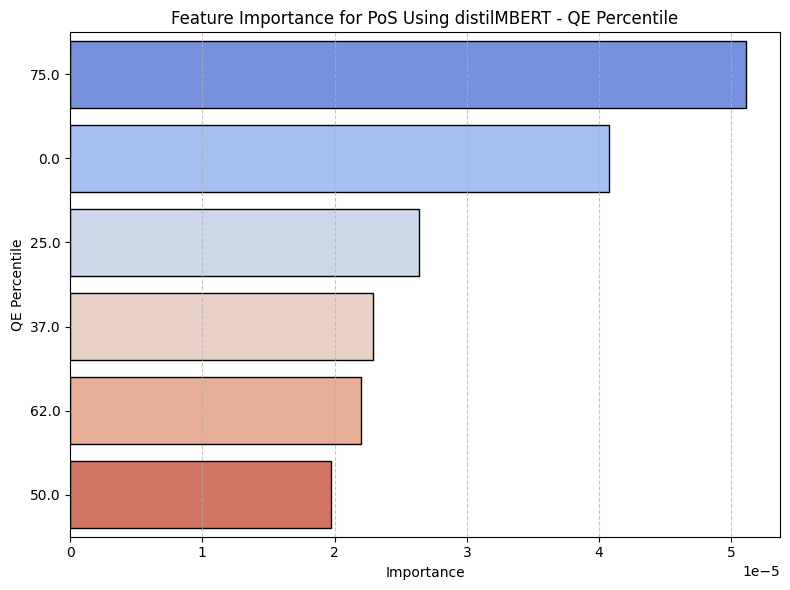

In [20]:
csv_directory_distilMBERT = './distilMBERT_percentile_data'
distilMBERT_baseline_df = load_and_combine_csvs(csv_directory_distilMBERT)

id_vars = ['method', 'value']
y_labels = {
    'Method': 'Method',
    'Language Code': 'Languages',
    'Value': 'QE Percentile'
}
melted_df = transform_data_for_regression(distilMBERT_baseline_df, id_vars)

subset_columns = ['method', 'language_code', 'value']
grouped_data = group_by_subset(melted_df, subset_columns)

rf_coefficients, feature_names = perform_random_forest_regression(grouped_data, id_vars)

plot_aggregated_coefficients(rf_coefficients, id_vars, feature_names, 'Aggregated Feature Importance for PoS using distilMBERT', y_labels)
plot_detailed_coefficients(rf_coefficients, id_vars, 'Feature Importance for PoS Using distilMBERT', custom_y_label='QE Percentile')

Number of duplicate rows: 1368
Unique combinations shape: (280, 4)
                             method value  accuracy language_code
0                  Before FastAlign   0.0  0.618363            ar
5                    Before Awesome   0.0  0.621756            ar
10                      Before Dict   0.0  0.593014            ar
15  Before - Front Freeze FastAlign   0.0  0.607186            ar
20    Before - Front Freeze Awesome   0.0  0.608583            ar
                         method language_code value  accuracy
0  Before - Back Freeze Awesome            ar   0.0  0.621756
1  Before - Back Freeze Awesome            ar  50.0  0.616128
2  Before - Back Freeze Awesome           avg   0.0  0.638004
3  Before - Back Freeze Awesome           avg  50.0  0.634541
4  Before - Back Freeze Awesome            bg   0.0  0.657535
Grouped DF Shape: (280, 4)


C:\Users\alith\AppData\Local\Temp\ipykernel_43892\1655974445.py:25: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  grouped_df = df.pivot_table(index=subset, values='accuracy', aggfunc='mean').reset_index()
C:\Users\alith\AppData\Local\Temp\ipykernel_43892\1212819453.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(y_tick_labels, fontsize=12)


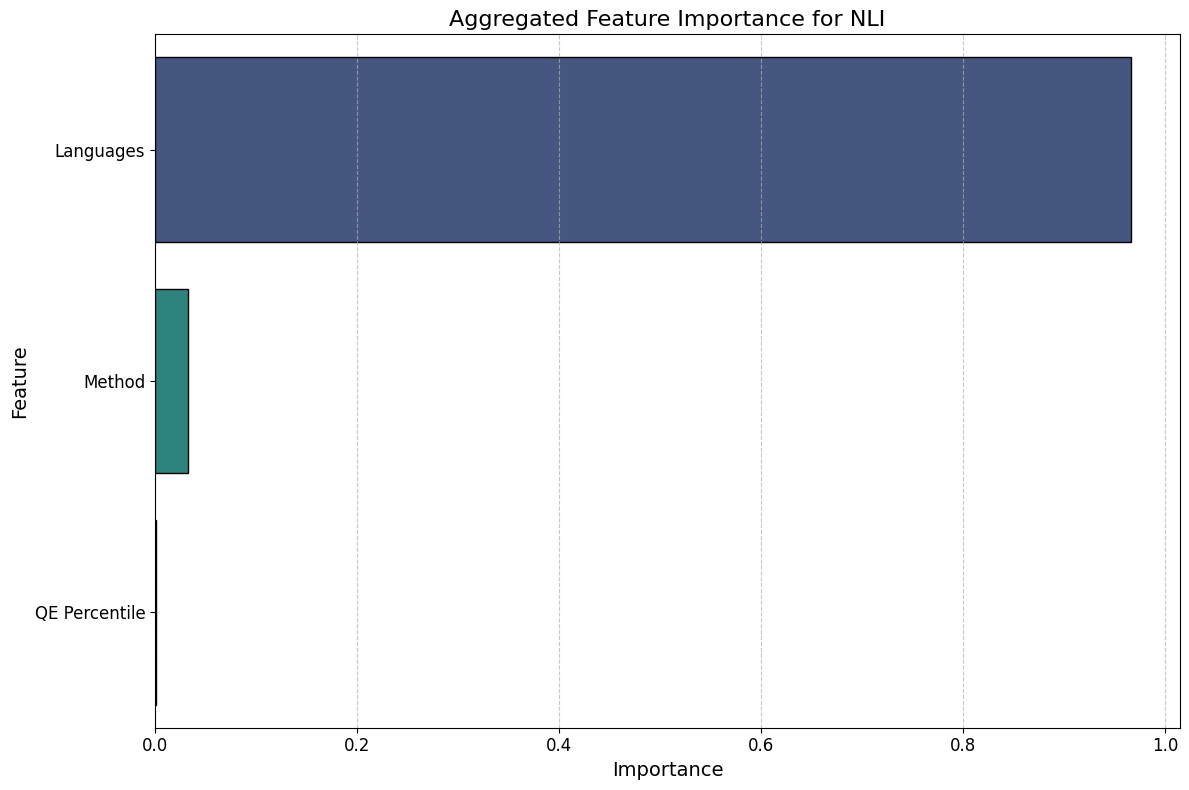

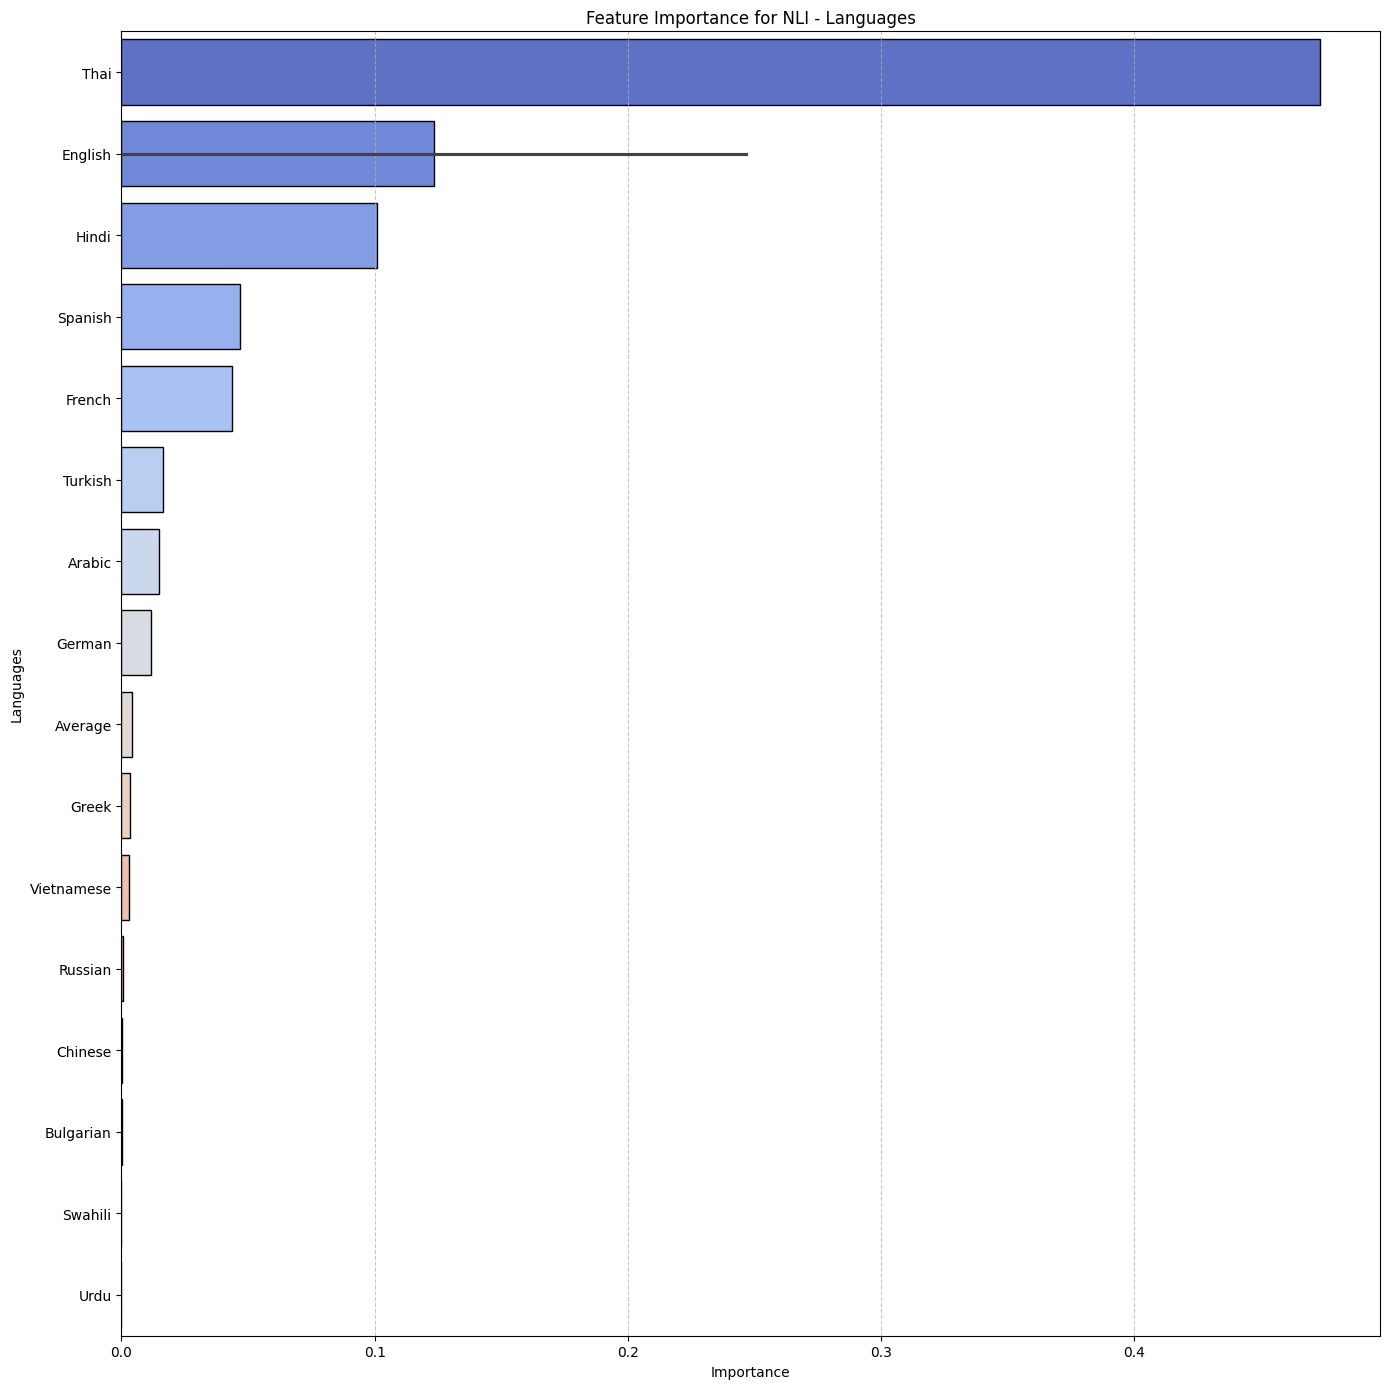

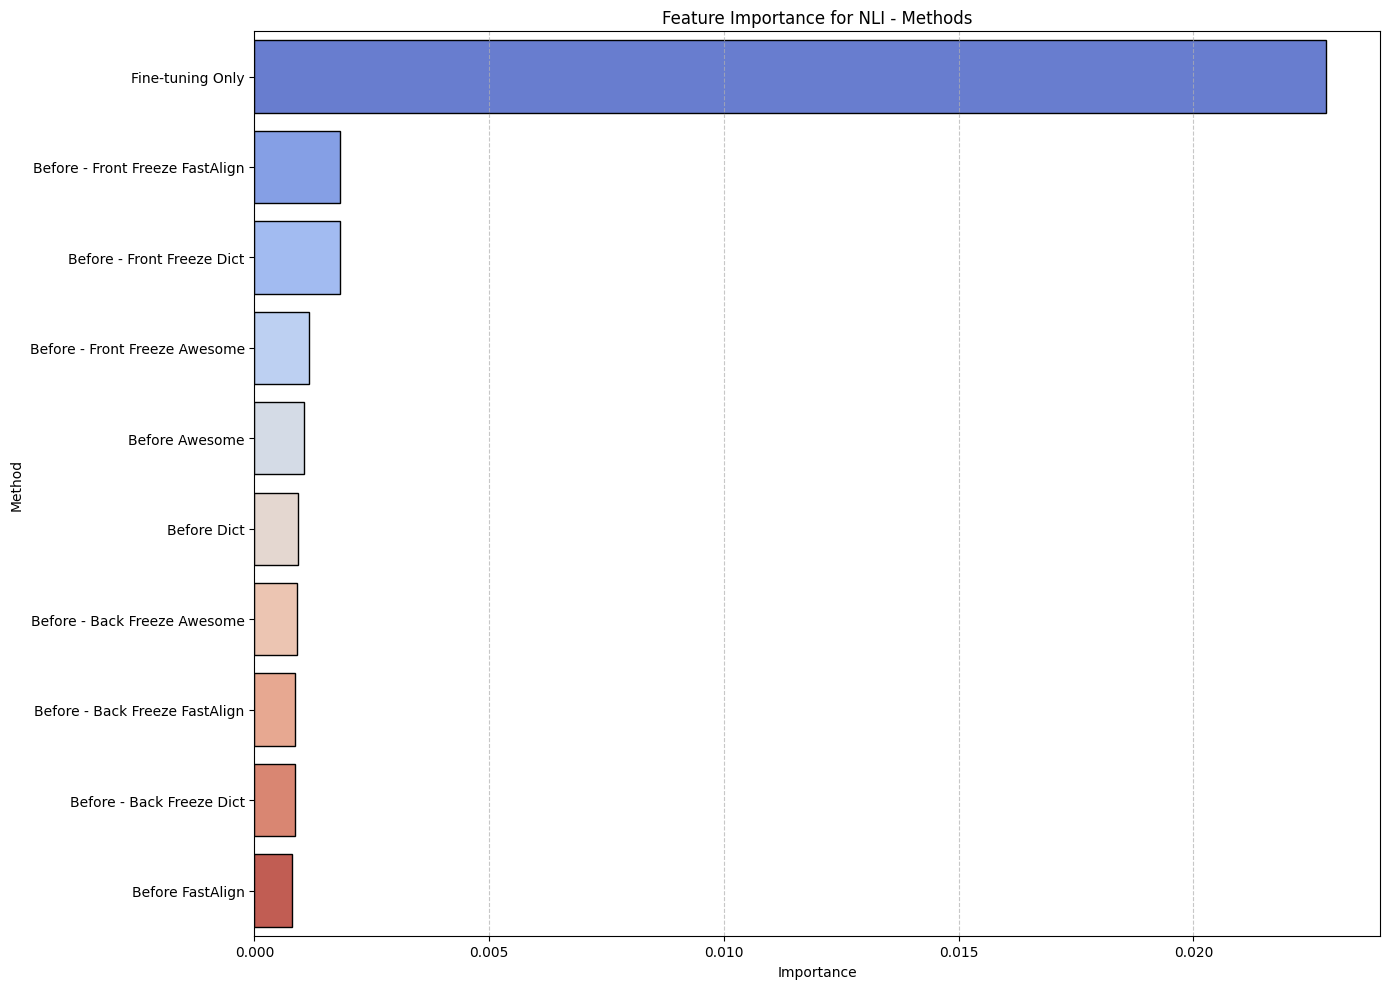

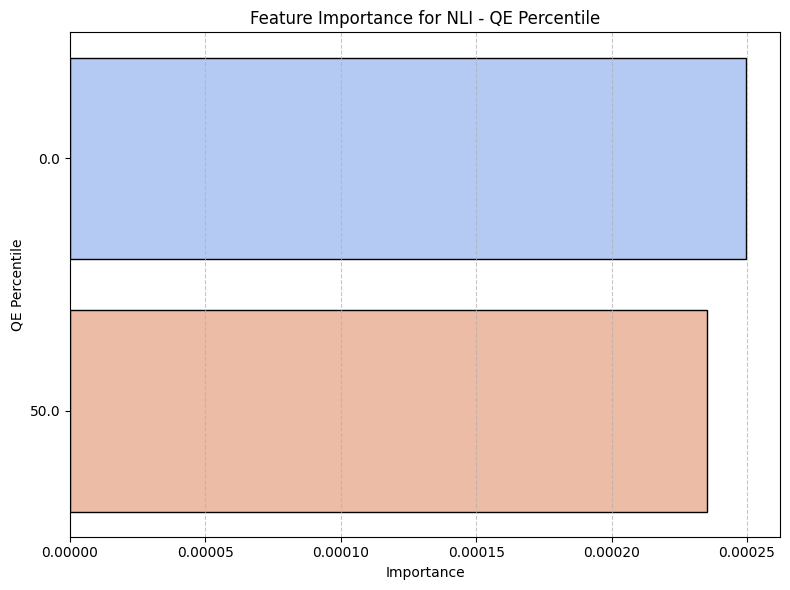

In [21]:
csv_directory_distilMBERT_NLI = './distilMBERT_nli_data'
distilMBERT_NLI_df = load_and_combine_csvs(csv_directory_distilMBERT_NLI)

id_vars = ['method', 'value']
y_labels = {
    'Method': 'Method',
    'Language Code': 'Languages',
    'Value': 'QE Percentile'
}
melted_df = transform_data_for_regression(distilMBERT_NLI_df, id_vars)

subset_columns = ['method', 'language_code', 'value']
grouped_data = group_by_subset(melted_df, subset_columns)

rf_coefficients, feature_names = perform_random_forest_regression(grouped_data, id_vars)

plot_aggregated_coefficients(rf_coefficients, id_vars, feature_names, 'Aggregated Feature Importance for NLI', y_labels)
plot_detailed_coefficients(rf_coefficients, id_vars, 'Feature Importance for NLI', custom_y_label='QE Percentile')

In [22]:
def plot_performance_vs_feature_importance(df, rf_coefficients, title=None):
    languages = df['language_code'].unique()

    results = []

    for language in languages:
        language_df = df[df['language_code'] == language]

        # Calculate the average baseline performance for the language
        baseline_avg = language_df[language_df['method'] == 'Fine-tuning Only']['accuracy'].mean()

        # Calculate the average performance for each language across all methods (excluding baseline)
        avg_performance = language_df[language_df['method'] != 'Fine-tuning Only'].groupby('method', observed=False)['accuracy'].mean().mean()

        # Calculate the performance change relative to the baseline
        performance_change = avg_performance - baseline_avg

        # Get the feature importance for the language
        feature_importance = rf_coefficients.get(f'language_code_{language}', 0)

        # Determine the language family and shape
        specific_family = specific_language_families.get(language, 'Other')
        shape = specific_family_shapes.get(specific_family, 'x')

        # Store the results
        results.append({
            'language': language_map.get(language, language),
            'performance_change': performance_change,
            'importance': feature_importance,
            'family': specific_family,
            'shape': shape
        })

    # Create a dataframe from the results
    results_df = pd.DataFrame(results)
    
    # Remove 'avg' and 'same' entries
    results_df = results_df[~results_df['language'].isin(['Average',])]

    # Split the results into two groups
    midpoint = len(results_df) // 2
    results_df_1 = results_df.iloc[:midpoint]
    results_df_2 = results_df.iloc[midpoint:]

    def plot_group(data, title_suffix):
        plt.figure(figsize=(14, 8))
        scatter_plot = sns.scatterplot(
            data=data, x='importance', y='performance_change', hue='language', style='family', 
            markers=specific_family_shapes, s=200, palette='tab20', legend='full'
        )
        
        plt.title(f'Performance Change vs. Feature Importance {title_suffix}' if title is None else title)
        plt.xlabel('Feature Importance')
        plt.ylabel('Performance Change (relative to Baseline)')
        plt.grid(True)

        # Get the current legend handles and labels
        handles, labels = scatter_plot.get_legend_handles_labels()

        # Separate the handles and labels for the languages and shapes
        language_handles = []
        language_labels = []
        family_handles = []
        family_labels = []

        for handle, label in zip(handles, labels):
            if label in specific_family_shapes:
                family_handles.append(handle)
                family_labels.append(label)
            else:
                language_handles.append(handle)
                language_labels.append(label.title())  # Titleize the language names

        # Ensure unique language handles/labels
        unique_language_labels = list(dict.fromkeys(language_labels))
        unique_language_handles = [plt.Line2D([], [], marker='D', color=handle.get_color(), linestyle='', markersize=10) for handle in language_handles]

        # Increase the size of the custom shape markers in the legend
        for handle in family_handles:
            handle.set_markersize(10)

        # Combine the unique language handles/labels and custom shape handles/labels
        new_handles = unique_language_handles + family_handles
        new_labels = unique_language_labels + family_labels

        # Position the legend outside of the plot
        plt.legend(handles=new_handles, labels=new_labels, title='', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
        plt.tight_layout()
        plt.show()

    # Plot the first group
    plot_group(results_df_1, "(Group 1)")

    # Plot the second group
    plot_group(results_df_2, "(Group 2)")

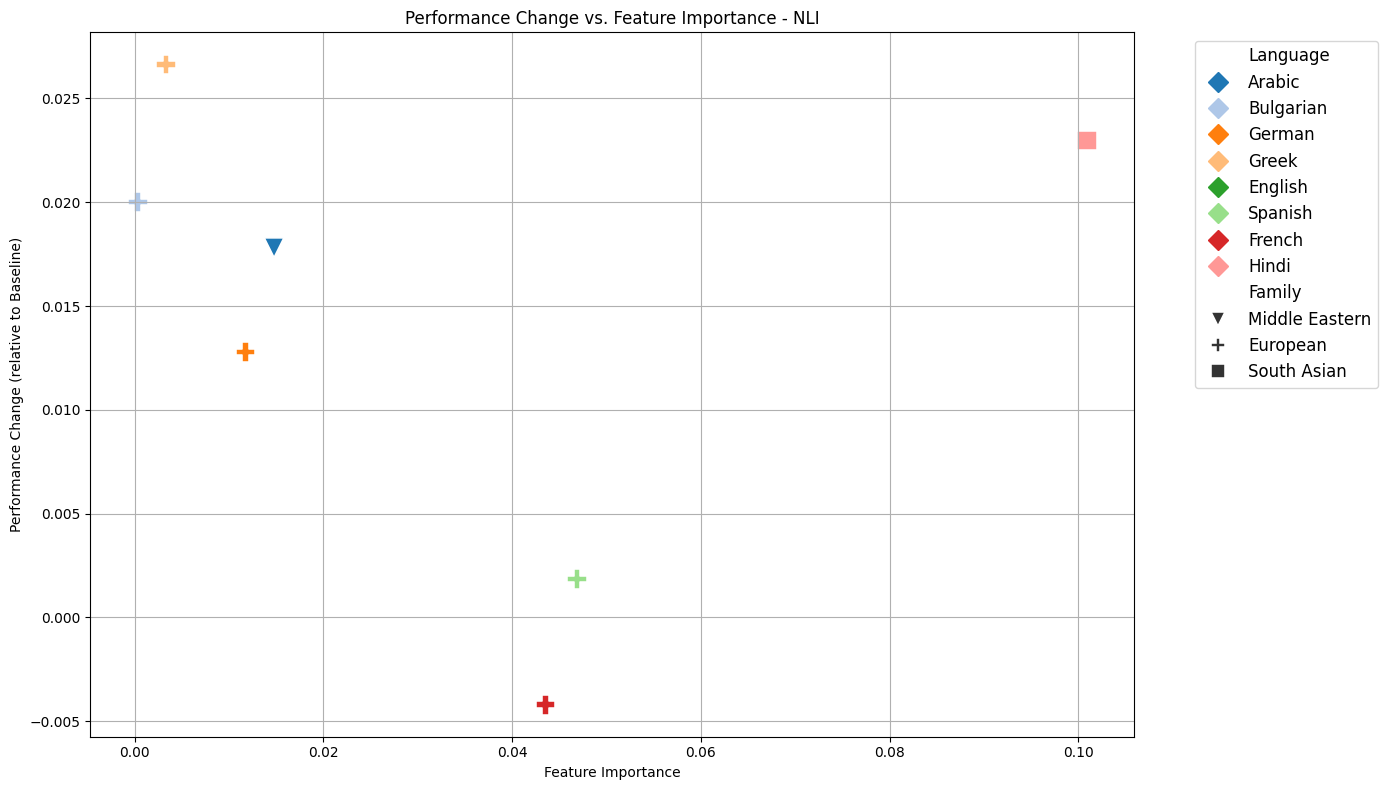

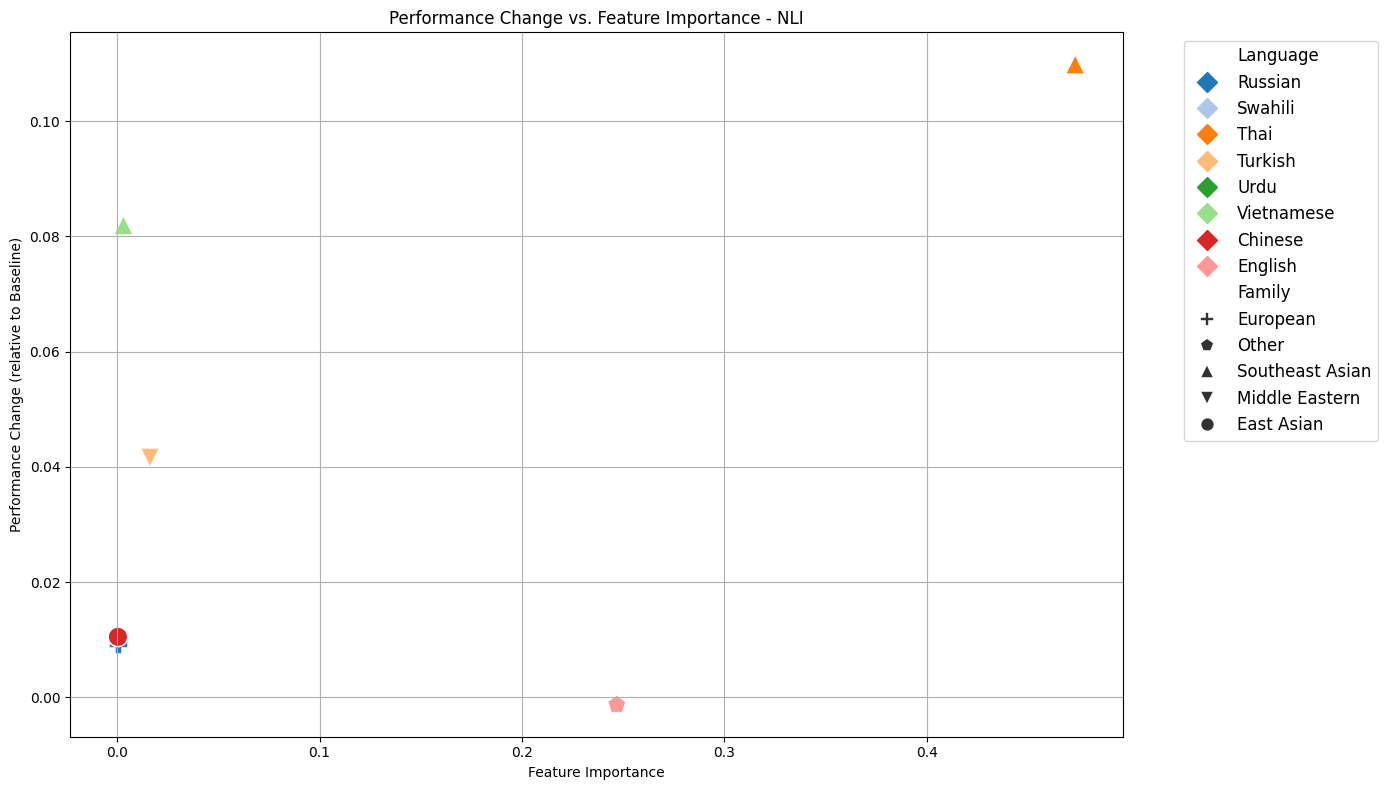

In [23]:
plot_performance_vs_feature_importance(melted_df, rf_coefficients, title='Performance Change vs. Feature Importance - NLI')

Number of duplicate rows: 17918
Unique combinations shape: (684, 3)
              method  accuracy language_code
0   Before FastAlign  0.875413            bg
5     Before Awesome  0.874968            bg
10       Before Dict  0.877448            bg
15  During FastAlign  0.865111            bg
20    During Awesome  0.865747            bg
                         method language_code  accuracy
0  Before - Back Freeze Awesome            af  0.865418
1  Before - Back Freeze Awesome            ar  0.634746
2  Before - Back Freeze Awesome           avg  0.772920
3  Before - Back Freeze Awesome            bg  0.873378
4  Before - Back Freeze Awesome            ca  0.879303
Grouped DF Shape: (684, 3)


C:\Users\alith\AppData\Local\Temp\ipykernel_43892\1655974445.py:25: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  grouped_df = df.pivot_table(index=subset, values='accuracy', aggfunc='mean').reset_index()


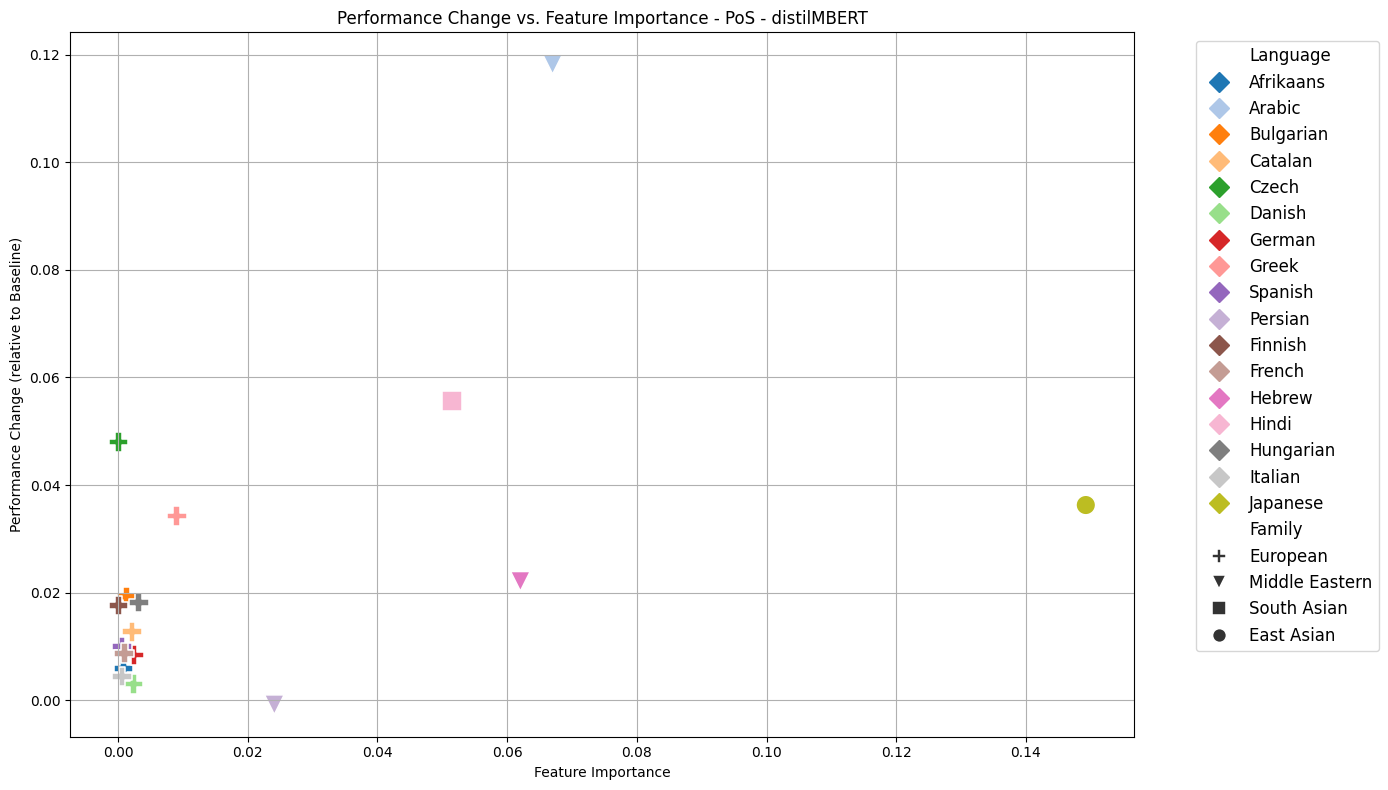

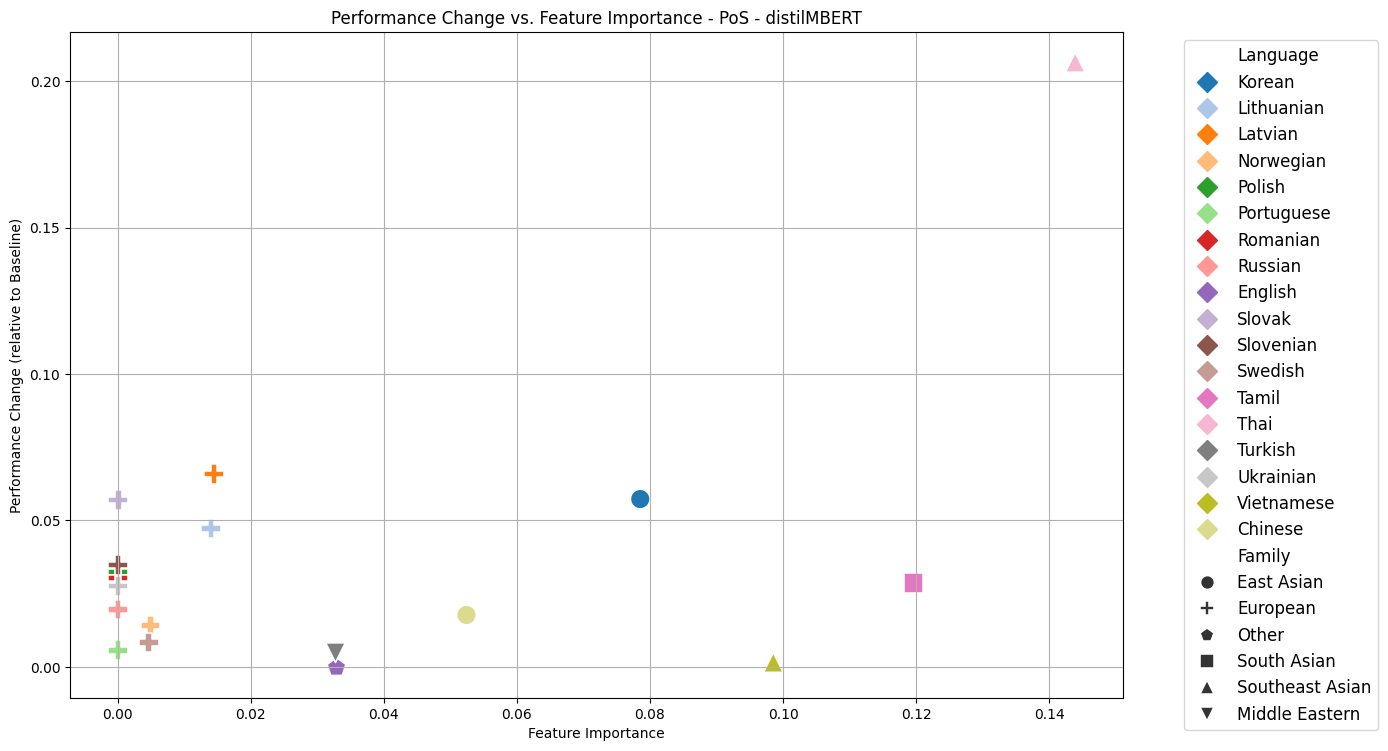

In [24]:
csv_directory_distilMBERT = './distilMBERT_percentile_data'
distilMBERT_baseline_df = load_and_combine_csvs(csv_directory_distilMBERT)

id_vars = ['method']
melted_df = transform_data_for_regression(distilMBERT_baseline_df, id_vars)

subset_columns = ['method', 'language_code']
grouped_data = group_by_subset(melted_df, subset_columns)

rf_coefficients, feature_names = perform_random_forest_regression(grouped_data, id_vars)

plot_performance_vs_feature_importance(grouped_data, rf_coefficients, title='Performance Change vs. Feature Importance - PoS - distilMBERT')